In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from tqdm.auto import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd

In [2]:
class Generator(nn.Module):
    def __init__(self, ngpu, nz = 100, ngf = 64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [3]:
ngpu = 1
device = torch.device("cuda:1" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
nz = 100

In [4]:
netG = torch.load('./models/experiment_1generator_45.pt')

torch.Size([8, 111, 1, 1])


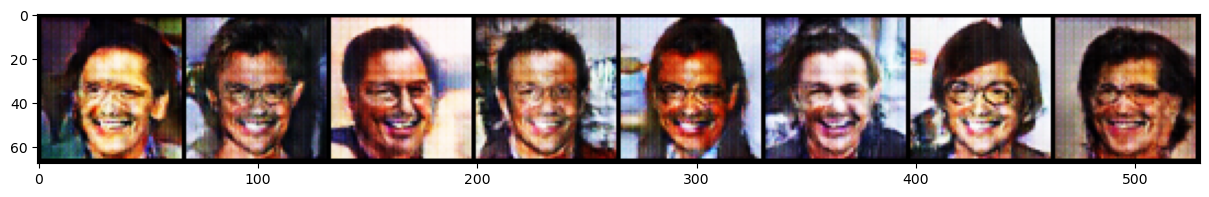

In [13]:
random_gen = torch.Generator(device=device)
random_gen.manual_seed(15)

num_images = 8
fixed_noise = torch.randn(num_images, nz, 1, 1, device=device, generator=random_gen)
reqd_labels = [
    'Attractive', 'Bald', 'Black_Hair', 'Blond_Hair', 'Chubby', 'Eyeglasses',  'Male', 'Mustache', 'Pale_Skin', 'Smiling', 'Young'
]
fixed_attributes = torch.Tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 3, 0]).to(device)
fixed_attributes = fixed_attributes.repeat(num_images, 1).reshape((num_images, 11, 1, 1))
fixed_noise = torch.cat((fixed_noise, fixed_attributes), 1)
print(fixed_noise.shape)
fake = netG(fixed_noise).detach().cpu()

fig = plt.figure(figsize=(15, 10))
temp_list = [vutils.make_grid(fake, padding=2, normalize=True)]
fake = netG(fixed_noise).detach().cpu()

temp_list.append(vutils.make_grid(fake, padding=2, normalize=True))
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in temp_list]
plt.savefig('./inference_plots/check_test4.png')